# Introduction to Convolutional Neural Networks ans Computer Vision with TensorFlow

Computer vision is the practice of writing algorithms which can discover patterns in visual data. Such as a camera of self-driving car recognizng the car in front.

In [1]:
import pathlib
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

## Get Data
The images we-re working with are from the Food101 dataset (101 different classes of food): https://www.kaggle.com/dansbecker/food-101

However we've modified it to only use two classes (pizza & steak) using the image data modification notebook: https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/extras/image_data_modification.ipynb

**Note:** We start with a smaller dataset so we can experiment quickly and figure what works (or better yet what doesn't work) before scaling up.

In [3]:
import requests

import zipfile

import io



# Download the zip file using requests

url = "https://storage.googleapis.com/ztm_tf_course/food_vision/pizza_steak.zip"

response = requests.get(url)



# Unzip the file in memory and extract it

with zipfile.ZipFile(io.BytesIO(response.content)) as zip_ref:

    zip_ref.extractall("pizza_steak")  # Extract to a folder called 'pizza_steak'

## Inspect the data (become one with it)

A very crucial step at beginning of any machine learning project is becoming one with the data.

And for a computer vision project... this usually means visualizing many samples of your data.

In [2]:
import os

# Walk through pizza_steak directory and list number of files
for dirpath, dirnames, filenames in os.walk('../data/pizza_steak'):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}")

There are 2 directories and 0 images in ../data/pizza_steak
There are 2 directories and 0 images in ../data/pizza_steak\test
There are 0 directories and 250 images in ../data/pizza_steak\test\pizza
There are 0 directories and 250 images in ../data/pizza_steak\test\steak
There are 2 directories and 0 images in ../data/pizza_steak\train
There are 0 directories and 750 images in ../data/pizza_steak\train\pizza
There are 0 directories and 750 images in ../data/pizza_steak\train\steak


In [3]:
# Anather way to find out how many images are in a file
num_steak_images_train = len(os.listdir("../data/pizza_steak/train/steak"))

num_steak_images_train

750

To visualize our images, first let's get the class names programmatically

In [4]:
# Get the classnames programmatically
import pathlib
import numpy as np
data_dir = pathlib.Path("../data/pizza_steak/train")
class_names = np.array(sorted([item.name for item in data_dir.glob("*")])) # Created a list of class_names from the subdirectories
print(class_names)

['pizza' 'steak']


In [5]:
# Let's visualize our images
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

def view_random_image(target_dir, target_class):
    # Setup the targeet dirctory (we'll view images from here)
    target_folder = target_dir + target_class

    # Get a random image path
    random_image = random.sample(os.listdir(target_folder), 1)

    # Read in the image and plot it using matplotlib
    img = mpimg.imread(target_folder + "/" + random_image[0])
    plt.imshow(img)
    plt.title(target_class)
    plt.axis("off")

    print(f"Image shape: {img.shape}") # show the shape of the image

    return img

Image shape: (512, 512, 3)


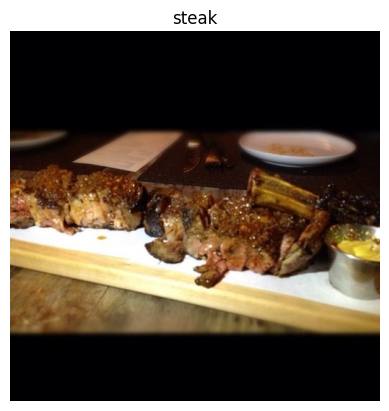

In [6]:
# View the training image from the training dataset
img = view_random_image(target_dir="../data/pizza_steak/train/",
                        target_class="steak")

In [7]:
tf.constant(img)

<tf.Tensor: shape=(512, 512, 3), dtype=uint8, numpy=
array([[[0, 0, 2],
        [0, 0, 2],
        [0, 0, 2],
        ...,
        [0, 0, 2],
        [0, 0, 2],
        [0, 0, 2]],

       [[0, 0, 2],
        [0, 0, 2],
        [0, 0, 2],
        ...,
        [0, 0, 2],
        [0, 0, 2],
        [0, 0, 2]],

       [[0, 0, 2],
        [0, 0, 2],
        [0, 0, 2],
        ...,
        [0, 0, 2],
        [0, 0, 2],
        [0, 0, 2]],

       ...,

       [[0, 0, 2],
        [0, 0, 2],
        [0, 0, 2],
        ...,
        [0, 0, 2],
        [0, 0, 2],
        [0, 0, 2]],

       [[0, 0, 2],
        [0, 0, 2],
        [0, 0, 2],
        ...,
        [0, 0, 2],
        [0, 0, 2],
        [0, 0, 2]],

       [[0, 0, 2],
        [0, 0, 2],
        [0, 0, 2],
        ...,
        [0, 0, 2],
        [0, 0, 2],
        [0, 0, 2]]], dtype=uint8)>

In [8]:
# View the image shape
img.shape # returns width, height, colour channels

(512, 512, 3)

> **Note:** As we've discussed before, many machine learning models, including neural networks prefer the values they work with to be between 0 and 1. Knowing this, one of the most common preprocessing steps for working with images is to **scale** (also reffered to as **normilize**) their pixel values by dividing the image arrays by 255. (since 255 is the maximum pixel value). 

## An end-to-end example

Let's build a convolutional neural network to find patterns in our images, more specifically we are need way to:
* Load our images
* Preprocess our images
* Build a CNN to find patterns in our images
* Compile our CNN
* Fit the CNN to our training data

> Outdated version

In [11]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# set the seed
tf.random.set_seed(42)

# Preprocess data (get all of the pixel values between 0 & 1, also called scaling/normalization)
train_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)

# Setup path to our directory
train_dir = '../data/pizza_steak/train'
test_dir = '../data/pizza_steak/test'

# Import data from directories and turn it into batches
train_data = train_datagen.flow_from_directory(directory=train_dir,
                                               batch_size=32,
                                               target_size=(224, 224),
                                               class_mode="binary",
                                               seed=42)
valid_data = valid_datagen.flow_from_directory(directory=test_dir,
                                               batch_size=32,
                                               target_size=(224, 224),
                                               class_mode="binary",
                                               seed=42)

print(valid_data.samples)

# Build a CNN model (same as the Tiny VGG on the CNN explainer webside)
model_1 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(224, 224, 3)),  # Явное указание входной формы
    tf.keras.layers.Conv2D(filters=10, kernel_size=3, activation='relu'),
    tf.keras.layers.Conv2D(10, 3, activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=2, padding='valid'),
    tf.keras.layers.Conv2D(10, 3, activation="relu"),
    tf.keras.layers.Conv2D(10, 3, activation="relu"),
    tf.keras.layers.MaxPool2D(2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile our CNN
model_1.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Fit the model
history_1 = model_1.fit(train_data,
                       epochs=5,
                       validation_data=valid_data,
                       validation_steps=None
                       )

Found 1500 images belonging to 2 classes.
Found 500 images belonging to 2 classes.
500
Epoch 1/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 10s 181ms/step - accuracy: 0.6732 - loss: 0.6052 - val_accuracy: 0.8420 - val_loss: 0.3819
Epoch 2/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 9s 174ms/step - accuracy: 0.7931 - loss: 0.4484 - val_accuracy: 0.7700 - val_loss: 0.4647
Epoch 3/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 9s 180ms/step - accuracy: 0.8082 - loss: 0.4312 - val_accuracy: 0.8660 - val_loss: 0.3445
Epoch 4/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 10s 191ms/step - accuracy: 0.8375 - loss: 0.3844 - val_accuracy: 0.8200 - val_loss: 0.4128
Epoch 5/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 9s 188ms/step - accuracy: 0.8516 - loss: 0.3621 - val_accuracy: 0.8580 - val_loss: 0.3326


> Updated version

In [15]:
# Import tools
import tensorflow as tf
from tensorflow.keras.utils import image_dataset_from_directory as Images

# Set seed
tf.random.set_seed(1)

# Set directory
images_dir_train = "../data/pizza_steak/train"
images_dir_test = "../data/pizza_steak/test"

# Load images and split them into batches (NO NEED TO DEFINE HOW MANY CLASSES HERE, SINCE IT WILL BE INFERRED FROM DIRECTORY STRUCTURE AUTOMATICALLY)
# Load images and split them into batches
images_train = Images(
    images_dir_train,
    image_size = (224, 224),
    batch_size = 32
)

images_test = Images(
    images_dir_test,
    image_size = (224, 224),
    batch_size = 32
)

# Set number of classes
num_classes = len(images_train.class_names)

# Build model, indicating Rescaling layer as a first layer
model_1 = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

# Compile model
model_1.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

# Train model
history_1 = model_1.fit(
  images_train,
  validation_data=images_test,
  epochs=5
)

Found 1500 files belonging to 2 classes.
Found 500 files belonging to 2 classes.
Epoch 1/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 14s 271ms/step - accuracy: 0.5844 - loss: 0.7372 - val_accuracy: 0.8140 - val_loss: 0.4466
Epoch 2/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 13s 277ms/step - accuracy: 0.7965 - loss: 0.4528 - val_accuracy: 0.8580 - val_loss: 0.3340
Epoch 3/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 15s 314ms/step - accuracy: 0.8194 - loss: 0.4052 - val_accuracy: 0.8480 - val_loss: 0.3457
Epoch 4/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 13s 278ms/step - accuracy: 0.8510 - loss: 0.3653 - val_accuracy: 0.8780 - val_loss: 0.3002
Epoch 5/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 14s 294ms/step - accuracy: 0.8701 - loss: 0.3130 - val_accuracy: 0.8440 - val_loss: 0.3573


In [16]:
model_1.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_2 (Rescaling)              │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_18 (Conv2D)                   │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_19 (Conv2D)                   │ (None, 109, 109, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_13 (MaxPooling2D)      │ (None, 54, 54, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_20 (Conv2D)                   │ (None, 52, 52, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_14 (MaxPooling2D)      │ (None, 26, 26, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_5 (Flatten)                  │ (None, 21632)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 128)                 │       2,769,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,366,024 (31.91 MB)

 Trainable params: 2,788,674 (10.64 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 5,577,350 (21.28 MB)

## Using the same model as before

Let's replicate the model we've build in a previous section to see if it works with our image data.

The model we're building is from Tensorflow playground

In [20]:
# Set random 
tf.random.set_seed(42)

# Create a model to replicate the TensorFlow Playground model
model_2 = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(224, 224, 3)),
    tf.keras.layers.Dense(4, activation='relu'),
    tf.keras.layers.Dense(4, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model
model_2.compile(loss=tf.keras.losses.BinaryCrossentropy,
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Fit the model
history_2 = model_2.fit(train_data,
                        epochs=5,
                        validation_data=images_test,
                       )

Epoch 1/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - accuracy: 0.5325 - loss: 1.7203 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 2/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 0.4932 - loss: 0.6934 - val_accuracy: 0.5000 - val_loss: 0.6933
Epoch 3/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - accuracy: 0.4876 - loss: 0.6936 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 4/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - accuracy: 0.5048 - loss: 0.6931 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 5/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - accuracy: 0.4930 - loss: 0.6934 - val_accuracy: 0.5000 - val_loss: 0.6932
